
 Detailed Recovery Report: Means
------------------------------------------------------------
[0,0] → True: 3.0000, Recovered: 2.7091, Error: 0.2909 →  OK
[0,1] → True: 0.1000, Recovered: 0.0623, Error: 0.0377 →  OK
[1,0] → True: 10.0000, Recovered: 8.2747, Error: 1.7253 →  OK
[1,1] → True: 0.3000, Recovered: 0.2491, Error: 0.0509 →  OK
[2,0] → True: 20.0000, Recovered: 17.7084, Error: 2.2916 → WRONG
[2,1] → True: 0.5000, Recovered: 0.4874, Error: 0.0126 →  OK
------------------------------------------------------------
Mean Absolute Error (MAE): 0.7348
PASS

 Detailed Recovery Report: Transition Matrix
------------------------------------------------------------
[0,0] → True: 0.5000, Recovered: 0.2906, Error: 0.2094 → WRONG
[0,1] → True: 0.2000, Recovered: 0.2943, Error: 0.0943 →  OK
[0,2] → True: 0.3000, Recovered: 0.4151, Error: 0.1151 →  OK
[1,0] → True: 0.2000, Recovered: 0.2433, Error: 0.0433 →  OK
[1,1] → True: 0.6000, Recovered: 0.4471, Error: 0.1529 →  OK
[1,2] → True: 0.2000

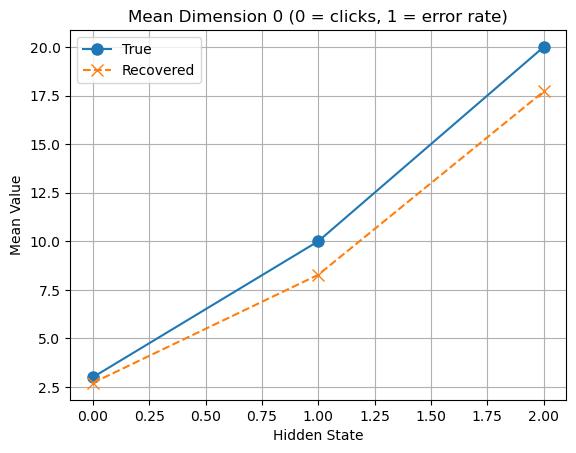

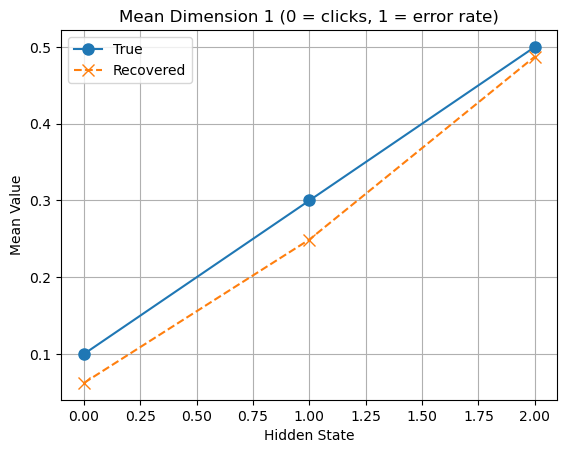

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

np.random.seed(1550)

# true model ---
true_model = hmm.GaussianHMM(n_components=3, covariance_type="full", init_params='', random_state=4)

true_model.startprob_ = np.array([0.3, 0.3, 0.4])
true_model.transmat_ = np.array([
    [0.5, 0.2, 0.3], 
    [0.2, 0.6, 0.2],
    [0.2, 0.3, 0.5]])

true_model.means_ = np.array([
    [3.0,  0.1],  #
    [10.0, 0.3], 
    [20.0, 0.5]])

true_model.covars_ = np.array([
    [[1.0, 0.05], [0.05, 0.02]],
    [[2.0, 0.10], [0.10, 0.05]], 
    [[3.0, 0.20], [0.20, 0.10]]])

# synthetic data 
n_samples = 2000
trials, simulated_states = true_model.sample(n_samples)
trials[:, 0] = np.random.poisson(lam=trials[:, 0]).astype(int)
trials[:, 1] = np.clip(trials[:, 1], 0, 1)
X_train = trials[:n_samples // 2]

# Fit a new model 
recovery_model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100, random_state=42)
recovery_model.fit(X_train)

# Align state labels ---
def align_states(true_means, recovered_means):
    cost_matrix = pairwise_distances(true_means, recovered_means)
    _, col_ind = linear_sum_assignment(cost_matrix)
    return col_ind

# reorder recovered parameters ---
def reorder_hmm_parameters(model, alignment_indices):
    reordered = {
        'means': model.means_[alignment_indices],
        'covars': model.covars_[alignment_indices],
        'startprob': model.startprob_[alignment_indices],
        'transmat': model.transmat_[alignment_indices][:, alignment_indices]
    }
    return reordered

alignment = align_states(true_model.means_, recovery_model.means_)
reordered = reorder_hmm_parameters(recovery_model, alignment)

# detailed reporting function 
def detailed_parameter_report(true, recovered, name="Parameter", threshold=0.5):
    print(f"\n Detailed Recovery Report: {name}")
    print("-" * 60)

    true = np.array(true)
    recovered = np.array(recovered)

    if true.ndim == 1:
        true = true.reshape(-1, 1)
        recovered = recovered.reshape(-1, 1)

    for i in range(true.shape[0]):
        for j in range(true.shape[1]):
            t_val = true[i, j]
            r_val = recovered[i, j]

            if np.isscalar(t_val):
                error = abs(t_val - r_val)
                passed = error < threshold
                status = " OK" if passed else "WRONG"
                print(f"[{i},{j}] → True: {t_val:.4f}, Recovered: {r_val:.4f}, Error: {error:.4f} → {status}")
            else:
                error = np.abs(t_val - r_val)
                mae = error.mean()
                passed = (error < threshold).all()
                status = "OK" if passed else "WRONG"
                print(f"[{i},{j}] → Block error (MAE): {mae:.4f} → {status}")

    mae_total = np.mean(np.abs(true - recovered))
    print("-" * 60)
    print(f"Mean Absolute Error (MAE): {mae_total:.4f}")
    print(f"{'PASS' if mae_total < threshold else f'FAIL (Above Threshold: {threshold})'}")

# --- Step 7: Run detailed reports ---
detailed_parameter_report(true_model.means_, reordered['means'], "Means", threshold=2.0)
detailed_parameter_report(true_model.transmat_, reordered['transmat'], "Transition Matrix", threshold=0.2)
detailed_parameter_report(true_model.startprob_, reordered['startprob'], "Start Probabilities", threshold=0.2)
detailed_parameter_report(true_model.covars_, reordered['covars'], "Covariances", threshold=1.0)

# --- Step 8: Visualize recovered vs true means ---
for dim in range(true_model.means_.shape[1]):
    plt.figure()
    plt.title(f"Mean Dimension {dim} (0 = clicks, 1 = error rate)")
    plt.plot(true_model.means_[:, dim], 'o-', label='True', markersize=8)
    plt.plot(reordered['means'][:, dim], 'x--', label='Recovered', markersize=8)
    plt.xlabel("Hidden State")
    plt.ylabel("Mean Value")
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

def evaluate_predictions(true_states, model, observations, alignment=None):
    """
    Predict hidden states with a model and compute accuracy vs. true states.
    Optionally align predicted states using alignment.
    """
    predicted_states = model.predict(observations)

    if alignment is not None:
        remapped_predicted = np.zeros_like(predicted_states)
        for i, a in enumerate(alignment):
            remapped_predicted[predicted_states == a] = i
        predicted_states = remapped_predicted

    accuracy = accuracy_score(true_states, predicted_states)
    print(f"\n Hidden State Prediction Accuracy: {accuracy * 100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(true_states, predicted_states, labels=[0, 1, 2])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1", "2"], yticklabels=["0", "1", "2"])
    plt.title("Confusion Matrix: True vs Predicted States")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return accuracy
